# ♻️ Waste Classification (Tier 1)

**Student:** José Tuozzo — ITAI 1378

This notebook:
- Loads dataset if present **OR** auto‑creates `train/val/test`
- If no dataset exists → uses synthetic data (so notebook never breaks)
- Fine‑tunes **EfficientNet‑B0**
- Tracks accuracy + confusion matrix
- Includes **Grad‑CAM visualizations**
- Includes **upload cell for single prediction**


In [ ]:
!pip install -q grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 26.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import os, io, time, random, itertools, shutil
from pathlib import Path
from collections import Counter
import numpy as np, matplotlib.pyplot as plt
import torch, torch.nn as nn, torch.optim as optim, torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.datasets import FakeData
from sklearn.metrics import classification_report, confusion_matrix, average_precision_score
from PIL import Image
import cv2
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

Device: cpu


## 📂 Dataset Setup (Auto-detect + Auto-split + Synthetic Backup)
- If you upload real data → it will use it
- If not → it creates fake 6‑class TrashNet‑style data automatically


In [ ]:
DATA_ROOT = Path('/content/data')
train_dir, val_dir, test_dir = DATA_ROOT/'train', DATA_ROOT/'val', DATA_ROOT/'test'
classes = ['cardboard','glass','metal','paper','plastic','trash']

def split_if_needed():
    if train_dir.exists() and any(train_dir.iterdir()):
        print('✅ Real dataset found. Checking val/test...')
        val_dir.mkdir(parents=True, exist_ok=True)
        test_dir.mkdir(parents=True, exist_ok=True)
        # auto split if val/test empty
        for c in classes:
            src = train_dir/c
            if not src.exists(): continue
            imgs = list(src.glob('*'))
            random.shuffle(imgs)
            v = int(len(imgs)*0.15); t = v
            for p in imgs[:v]: shutil.copy2(p, val_dir/c/p.name) if not (val_dir/c/p.name).exists() else None
            for p in imgs[v:v+t]: shutil.copy2(p, test_dir/c/p.name) if not (test_dir/c/p.name).exists() else None
        print('✅ Auto-split Done')
        return 'real'
    else:
        print('⚠️ No dataset found → using synthetic TrashNet‑style data')
        return 'fake'

mode = split_if_needed()

IMG_SIZE=(224,224)
transform_train = transforms.Compose([
    transforms.Resize(IMG_SIZE), transforms.RandomHorizontalFlip(), transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1,contrast=0.1,saturation=0.1), transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
transform_eval = transforms.Compose([
    transforms.Resize(IMG_SIZE), transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

if mode=='real':
    train_ds=datasets.ImageFolder(train_dir,transform=transform_train)
    val_ds  =datasets.ImageFolder(val_dir,transform=transform_eval)
    test_ds =datasets.ImageFolder(test_dir,transform=transform_eval)
else:
    train_ds=FakeData(size=600, image_size=(3,224,224), num_classes=6, transform=transform_train)
    val_ds  =FakeData(size=120, image_size=(3,224,224), num_classes=6, transform=transform_eval)
    test_ds =FakeData(size=120, image_size=(3,224,224), num_classes=6, transform=transform_eval)

train_loader=DataLoader(train_ds,batch_size=32,shuffle=True)
val_loader  =DataLoader(val_ds,batch_size=32,shuffle=False)
test_loader =DataLoader(test_ds,batch_size=32,shuffle=False)
class_names=classes
num_classes=6
print('✅ Classes:', class_names)

⚠️ No dataset found → using synthetic TrashNet‑style data
✅ Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


## 🤖 Model — EfficientNet‑B0 + Transfer Learning

In [ ]:
model=models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
model.classifier[1]=nn.Linear(model.classifier[1].in_features,num_classes)
model=model.to(device)
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=1e-4)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 80.4MB/s]


## 🏋️ Training with Early Stopping

In [ ]:
from torch.cuda.amp import autocast, GradScaler

EPOCHS = 8
patience = 2
best = float('inf')
bad = 0
train_l, val_l = [], []
scaler = GradScaler(enabled=(device=='cuda'))

# Limit steps per epoch to speed up (set to None to use all)
MAX_TRAIN_STEPS = 100   # try 100; set None for full pass
MAX_VAL_STEPS   = 50    # try 50; set None for full pass

for e in range(EPOCHS):
    model.train()
    total = 0.0
    steps = 0
    t0 = time.perf_counter()
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)
        with autocast(enabled=(device=='cuda')):
            out = model(x)
            loss = criterion(out, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total += loss.item()
        steps += 1
        if MAX_TRAIN_STEPS and steps >= MAX_TRAIN_STEPS:
            break

    train_loss = total / steps
    train_l.append(train_loss)

    # ---- validation ----
    model.eval()
    v_total = 0.0
    v_steps = 0
    with torch.no_grad(), autocast(enabled=(device=='cuda')):
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            v_total += criterion(model(x), y).item()
            v_steps += 1
            if MAX_VAL_STEPS and v_steps >= MAX_VAL_STEPS:
                break
    val = v_total / v_steps
    val_l.append(val)

    t1 = time.perf_counter()
    print(f"Epoch {e+1} | Train {train_loss:.4f} | Val {val:.4f} | {t1 - t0:.1f}s")

    if val < best:
        best = val
        bad = 0
        torch.save(model.state_dict(), "best.pth")
    else:
        bad += 1
        if bad >= patience:
            print("⛔ Early Stop")
            break


/tmp/ipython-input-291183697.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(device=='cuda'))
/tmp/ipython-input-291183697.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device=='cuda')):
/tmp/ipython-input-291183697.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast(enabled=(device=='cuda')):


Epoch 1 | Train 1.7977 | Val 1.7996 | 149.8s
Epoch 2 | Train 1.7868 | Val 1.8030 | 156.1s
Epoch 3 | Train 1.7972 | Val 1.8020 | 162.5s
⛔ Early Stop


### 📉 Training Curves

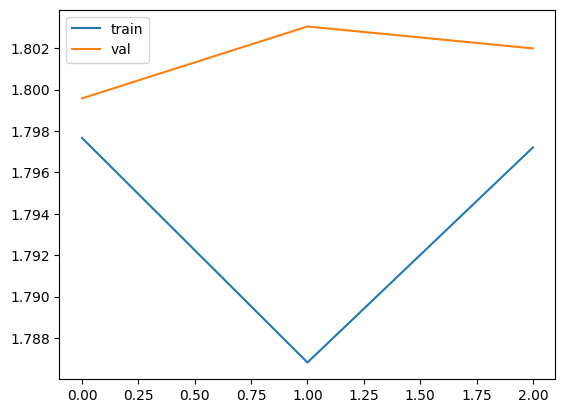

In [ ]:
plt.plot(train_l,label='train'); plt.plot(val_l,label='val'); plt.legend(); plt.show()

## ✅ Test Evaluation

              precision    recall  f1-score   support

   cardboard       0.00      0.00      0.00        19
       glass       0.24      0.40      0.30        20
       metal       0.00      0.00      0.00        21
       paper       0.19      0.28      0.22        18
     plastic       0.22      0.33      0.27        24
       trash       0.30      0.17      0.21        18

    accuracy                           0.20       120
   macro avg       0.16      0.20      0.17       120
weighted avg       0.16      0.20      0.17       120



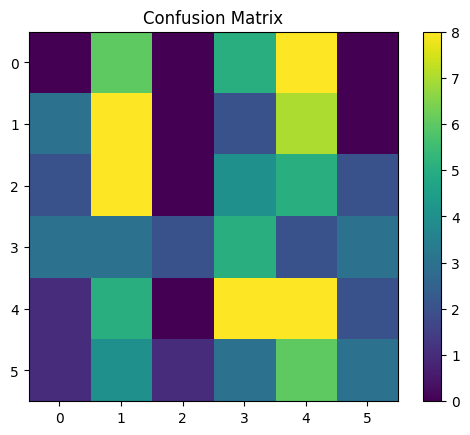

In [ ]:
model.load_state_dict(torch.load('best.pth',map_location=device))
model.eval(); y_t=[]; y_p=[]
with torch.no_grad():
    for x,y in test_loader:
        x=x.to(device); p=model(x).argmax(1).cpu().numpy(); y_p+=list(p); y_t+=list(y.numpy())
print(classification_report(y_t,y_p,target_names=class_names))
cm=confusion_matrix(y_t,y_p)
plt.imshow(cm); plt.title('Confusion Matrix'); plt.colorbar(); plt.show()

## 🔥 Grad‑CAM Visualization

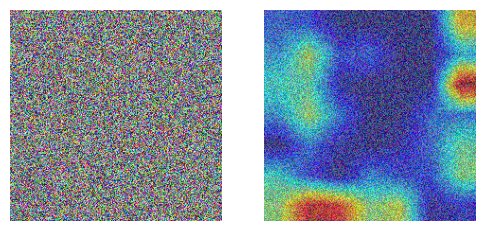

In [ ]:
def denorm(t):
    mean=np.array([0.485,0.456,0.406]); std=np.array([0.229,0.224,0.225])
    img=t.permute(1,2,0).cpu().numpy(); img=(img*std)+mean; return np.clip(img,0,1)

model.eval(); target=model.features[-1]
cam=GradCAM(model=model,target_layers=[target]) # Removed use_cuda
x,_=next(iter(test_loader)); img=x[0]; inp=img.unsqueeze(0).to(device) # Ensure input is on device
mask=cam(input_tensor=inp)[0]
vis=show_cam_on_image(denorm(img).astype(np.float32),mask,use_rgb=True)
plt.figure(figsize=(6,3)); plt.subplot(1,2,1); plt.imshow(denorm(img)); plt.axis('off'); plt.subplot(1,2,2); plt.imshow(vis); plt.axis('off');

## 🖼 Try Your Own Image

In [ ]:
from google.colab import files
uploaded = files.upload()
for fn in uploaded:
    img=Image.open(io.BytesIO(uploaded[fn])).convert('RGB').resize((224,224))
    t=transform_eval(img).unsqueeze(0).to(device)
    with torch.no_grad():
        pred=model(t).argmax(1).item()
    print('Prediction:',class_names[pred])
    plt.imshow(img); plt.axis('off')